In [2]:
!gdown https://drive.google.com/uc?id=1Fxv32_ConX1dw3RldPEBrvPSbibvafeh

Downloading...
From: https://drive.google.com/uc?id=1Fxv32_ConX1dw3RldPEBrvPSbibvafeh
To: /content/Activity_Measurements_reduced.zip
100% 353M/353M [00:05<00:00, 69.4MB/s]


In [3]:
!unzip Activity_Measurements_reduced.zip

Archive:  Activity_Measurements_reduced.zip
  inflating: Activity_Measurements/GOTOV05-GENEActiv-ankle.csv  
  inflating: Activity_Measurements/GOTOV05-GENEActiv-chest.csv  
  inflating: Activity_Measurements/GOTOV05-GENEActiv-wrist.csv  
  inflating: Activity_Measurements/GOTOV06-GENEActiv-ankle.csv  
  inflating: Activity_Measurements/GOTOV06-GENEActiv-chest.csv  
  inflating: Activity_Measurements/GOTOV06-GENEActiv-wrist.csv  
  inflating: Activity_Measurements/GOTOV07-GENEActiv-ankle.csv  
  inflating: Activity_Measurements/GOTOV07-GENEActiv-chest.csv  
  inflating: Activity_Measurements/GOTOV07-GENEActiv-wrist.csv  
  inflating: Activity_Measurements/GOTOV08-GENEActiv-ankle.csv  
  inflating: Activity_Measurements/GOTOV08-GENEActiv-chest.csv  
  inflating: Activity_Measurements/GOTOV08-GENEActiv-wrist.csv  
  inflating: Activity_Measurements/GOTOV09-GENEActiv-ankle.csv  
  inflating: Activity_Measurements/GOTOV09-GENEActiv-chest.csv  
  inflating: Activity_Measurements/GOTOV09-GEN

In [4]:
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyts.image import GramianAngularField
import numpy as np
import os

def read_and_normalize_data(sensor_type, folder_path):
    sensor_data = pd.DataFrame()
    num = 1
    for filename in os.listdir(folder_path):
        if filename.endswith(f"-GENEActiv-{sensor_type}.csv"):
            file_path = os.path.join(folder_path, filename)
            user_name = filename.split('-')[0]

            # Read CSV file
            df = pd.read_csv(file_path)

            # Add user name as a column and concatenate to the sensor_data DataFrame
            df['user'] = user_name
            new_data = pd.concat([pd.DataFrame(df['x']),pd.DataFrame(df['y']),pd.DataFrame(df['z']),pd.DataFrame(df['labels']),pd.DataFrame(df['user'])],axis=1)
            sensor_data = pd.concat([sensor_data,new_data],axis=0)
            num+=1
            if num>9:
              break
    return sensor_data

# Function to create GAF images for activity recognition
def create_gaf_images(sensor_data, window_size):
    images = []
    labels = []  # Assuming labels are present in the original dataset

    unique_users = sensor_data['user'].unique()
    print(unique_users)
    train_users = unique_users[0:-2]
    val_users = unique_users[-2]
    test_users = unique_users[-1]
    # Combine all data for normalization
    combined_data = pd.DataFrame()

    # training data
    for user in train_users:
        user_data = sensor_data[sensor_data['user'] == user]
        combined_data = pd.concat([combined_data, user_data])

    # Extract features and labels
    features = combined_data.iloc[:, 0:-2].values  # Exclude 'user' and 'labels' columns

    # Normalize the entire dataset
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    start_index = 0
    for user in unique_users:
        user_data = sensor_data[sensor_data['user'] == user]


            # Check if all labels in the window are the same

        while start_index + window_size <= len(user_data):
            label = user_data.iloc[start_index]['labels']  # Use the label of the first entry in the window
            if user_data.iloc[start_index:start_index + window_size]['labels'].nunique() == 1:
             # Extract and reshape window data for each column (x, y, z)
              curr_img = np.zeros((window_size,window_size,3))
              for col_index in range(normalized_features.shape[1]):
                  col_window = normalized_features[start_index:start_index + window_size, col_index]
                  reshaped_col_window = col_window.reshape(1, window_size)

                  # Create GAF images using GASF for each column
                  gasf = GramianAngularField()
                  image = gasf.fit_transform(reshaped_col_window)
                  curr_img[:,:,col_index] = image
                  # Add each channel image to the list
              images.append(curr_img)
              labels.append(user_data.iloc[start_index]['labels'])

            start_index += window_size

    images = np.array(images)
    labels = np.array(labels)



    return images, labels





# Main script
folder_path = "/content/Activity_Measurements"
window_size = 100  # Adjust window size based on your requirements

# Read and normalize data for each sensor type
ankle_data = read_and_normalize_data("ankle", folder_path)
# chest_data = read_and_normalize_data("chest", folder_path)
# wrist_data = read_and_normalize_data("wrist", folder_path)

# Create windows for each sensor type
ankle_windows = create_gaf_images(ankle_data, window_size)
# chest_windows = create_gaf_images(chest_data, window_size)
# wrist_windows = create_gaf_images(wrist_data, window_size)



['GOTOV29' 'GOTOV17' 'GOTOV09' 'GOTOV27' 'GOTOV25' 'GOTOV33' 'GOTOV14'
 'GOTOV05' 'GOTOV28']


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_array = label_encoder.fit_transform(ankle_windows[1])


In [7]:
ankle_windows[0]

array([[[[-0.87095756, -0.4830262 , -0.91168117],
         [-0.84038821, -0.39645539, -0.93848353],
         [-0.84969092, -0.3409512 , -0.96437504],
         ...,
         [-0.4998542 , -0.99937833, -0.99471587],
         [-0.46284077, -0.93676223, -0.99866891],
         [-0.80794641, -0.95167302, -0.93397619]],

        [[-0.84038821, -0.39645539, -0.93848353],
         [-0.80687957, -0.306199  , -0.96057625],
         [-0.81703522, -0.24883148, -0.98068353],
         ...,
         [-0.44778071, -0.99133774, -0.9849516 ],
         [-0.4096301 , -0.89870432, -0.99981466],
         [-0.77170011, -0.91767281, -0.95693057]],

        [[-0.84969092, -0.3409512 , -0.96437504],
         [-0.81703522, -0.24883148, -0.98068353],
         [-0.82694351, -0.19057665, -0.9937332 ],
         ...,
         [-0.46327001, -0.9817309 , -0.96675893],
         [-0.42544024, -0.87092525, -0.99458528],
         [-0.78264874, -0.89232018, -0.97809349]],

        ...,

        [[-0.4998542 , -0.99937833, -0

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
image_size = 100
num_classes = 17
# Assuming you have a dataset with images and corresponding labels
# X_train: array of images, y_train: array of labels
# Ensure that your images and labels are properly loaded

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ankle_windows[0], encoded_array, test_size=0.2, random_state=42)

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Adding dropout for regularization

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Adding dropout for regularization

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))  # Adding dropout for regularization

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Adding dropout for regularization

model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(X_train,y_train, epochs=100,validation_data=(X_test, y_test),callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')


Epoch 1/100
79/79 [==============================] - 18s 25ms/step - loss: 2.4765 - accuracy: 0.3109 - val_loss: 2.3108 - val_accuracy: 0.3318
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 2.2575 - accuracy: 0.3315 - val_loss: 2.0177 - val_accuracy: 0.3712
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 2.0040 - accuracy: 0.3608 - val_loss: 1.9117 - val_accuracy: 0.3665
Epoch 4/100
79/79 [==============================] - 1s 19ms/step - loss: 1.9047 - accuracy: 0.3703 - val_loss: 1.8134 - val_accuracy: 0.3823
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 1.8071 - accuracy: 0.3833 - val_loss: 1.7690 - val_accuracy: 0.3839
Epoch 6/100
79/79 [==============================] - 2s 20ms/step - loss: 1.7891 - accuracy: 0.3817 - val_loss: 1.7237 - val_accuracy: 0.3902
Epoch 7/100
79/79 [==============================] - 1s 18ms/step - loss: 1.7225 - accuracy: 0.4039 - val_loss: 1.6419 - val_accuracy: 0.3981
Epoch

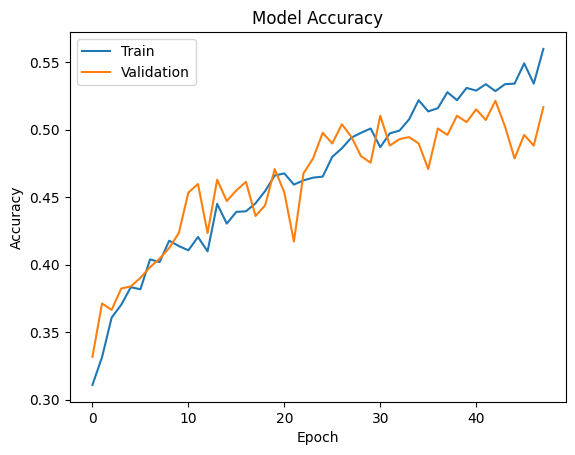

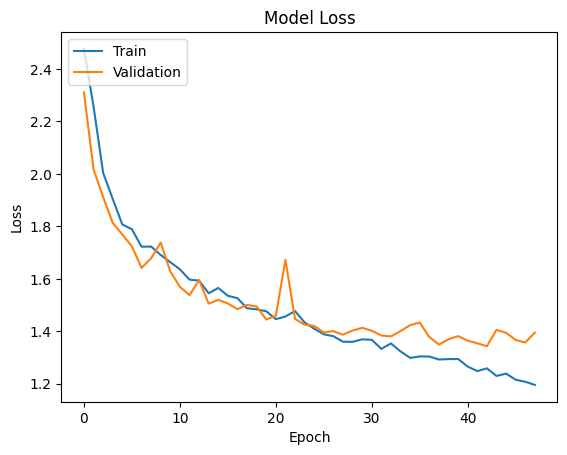

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the fit method
# history = model.fit(...)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
X_test[0].shape

(100, 100, 3)

In [17]:
nTrue = 0
for i in range(100):
  input_data = np.expand_dims(X_test[i], axis=0)

  predictions = model.predict(input_data)
  predicted_class = np.argmax(predictions, axis=1)
  if predicted_class==y_test[i]:
    nTrue+=1
  print("Predicted class:", predicted_class,"......True class:",y_test[i])
print("Correct Prediction Probability  is:",nTrue/100)

1/1 [==============================] - 0s 21ms/step
Predicted class: [5] ......True class: 9
1/1 [==============================] - 0s 24ms/step
Predicted class: [0] ......True class: 5
1/1 [==============================] - 0s 17ms/step
Predicted class: [0] ......True class: 2
1/1 [==============================] - 0s 17ms/step
Predicted class: [8] ......True class: 8
1/1 [==============================] - 0s 19ms/step
Predicted class: [7] ......True class: 7
1/1 [==============================] - 0s 21ms/step
Predicted class: [1] ......True class: 8
1/1 [==============================] - 0s 24ms/step
Predicted class: [8] ......True class: 7
1/1 [==============================] - 0s 18ms/step
Predicted class: [0] ......True class: 3
1/1 [==============================] - 0s 24ms/step
Predicted class: [2] ......True class: 3
1/1 [==============================] - 0s 18ms/step
Predicted class: [12] ......True class: 12
1/1 [==============================] - 0s 17ms/step
Predicted class: